# On the Menu today!

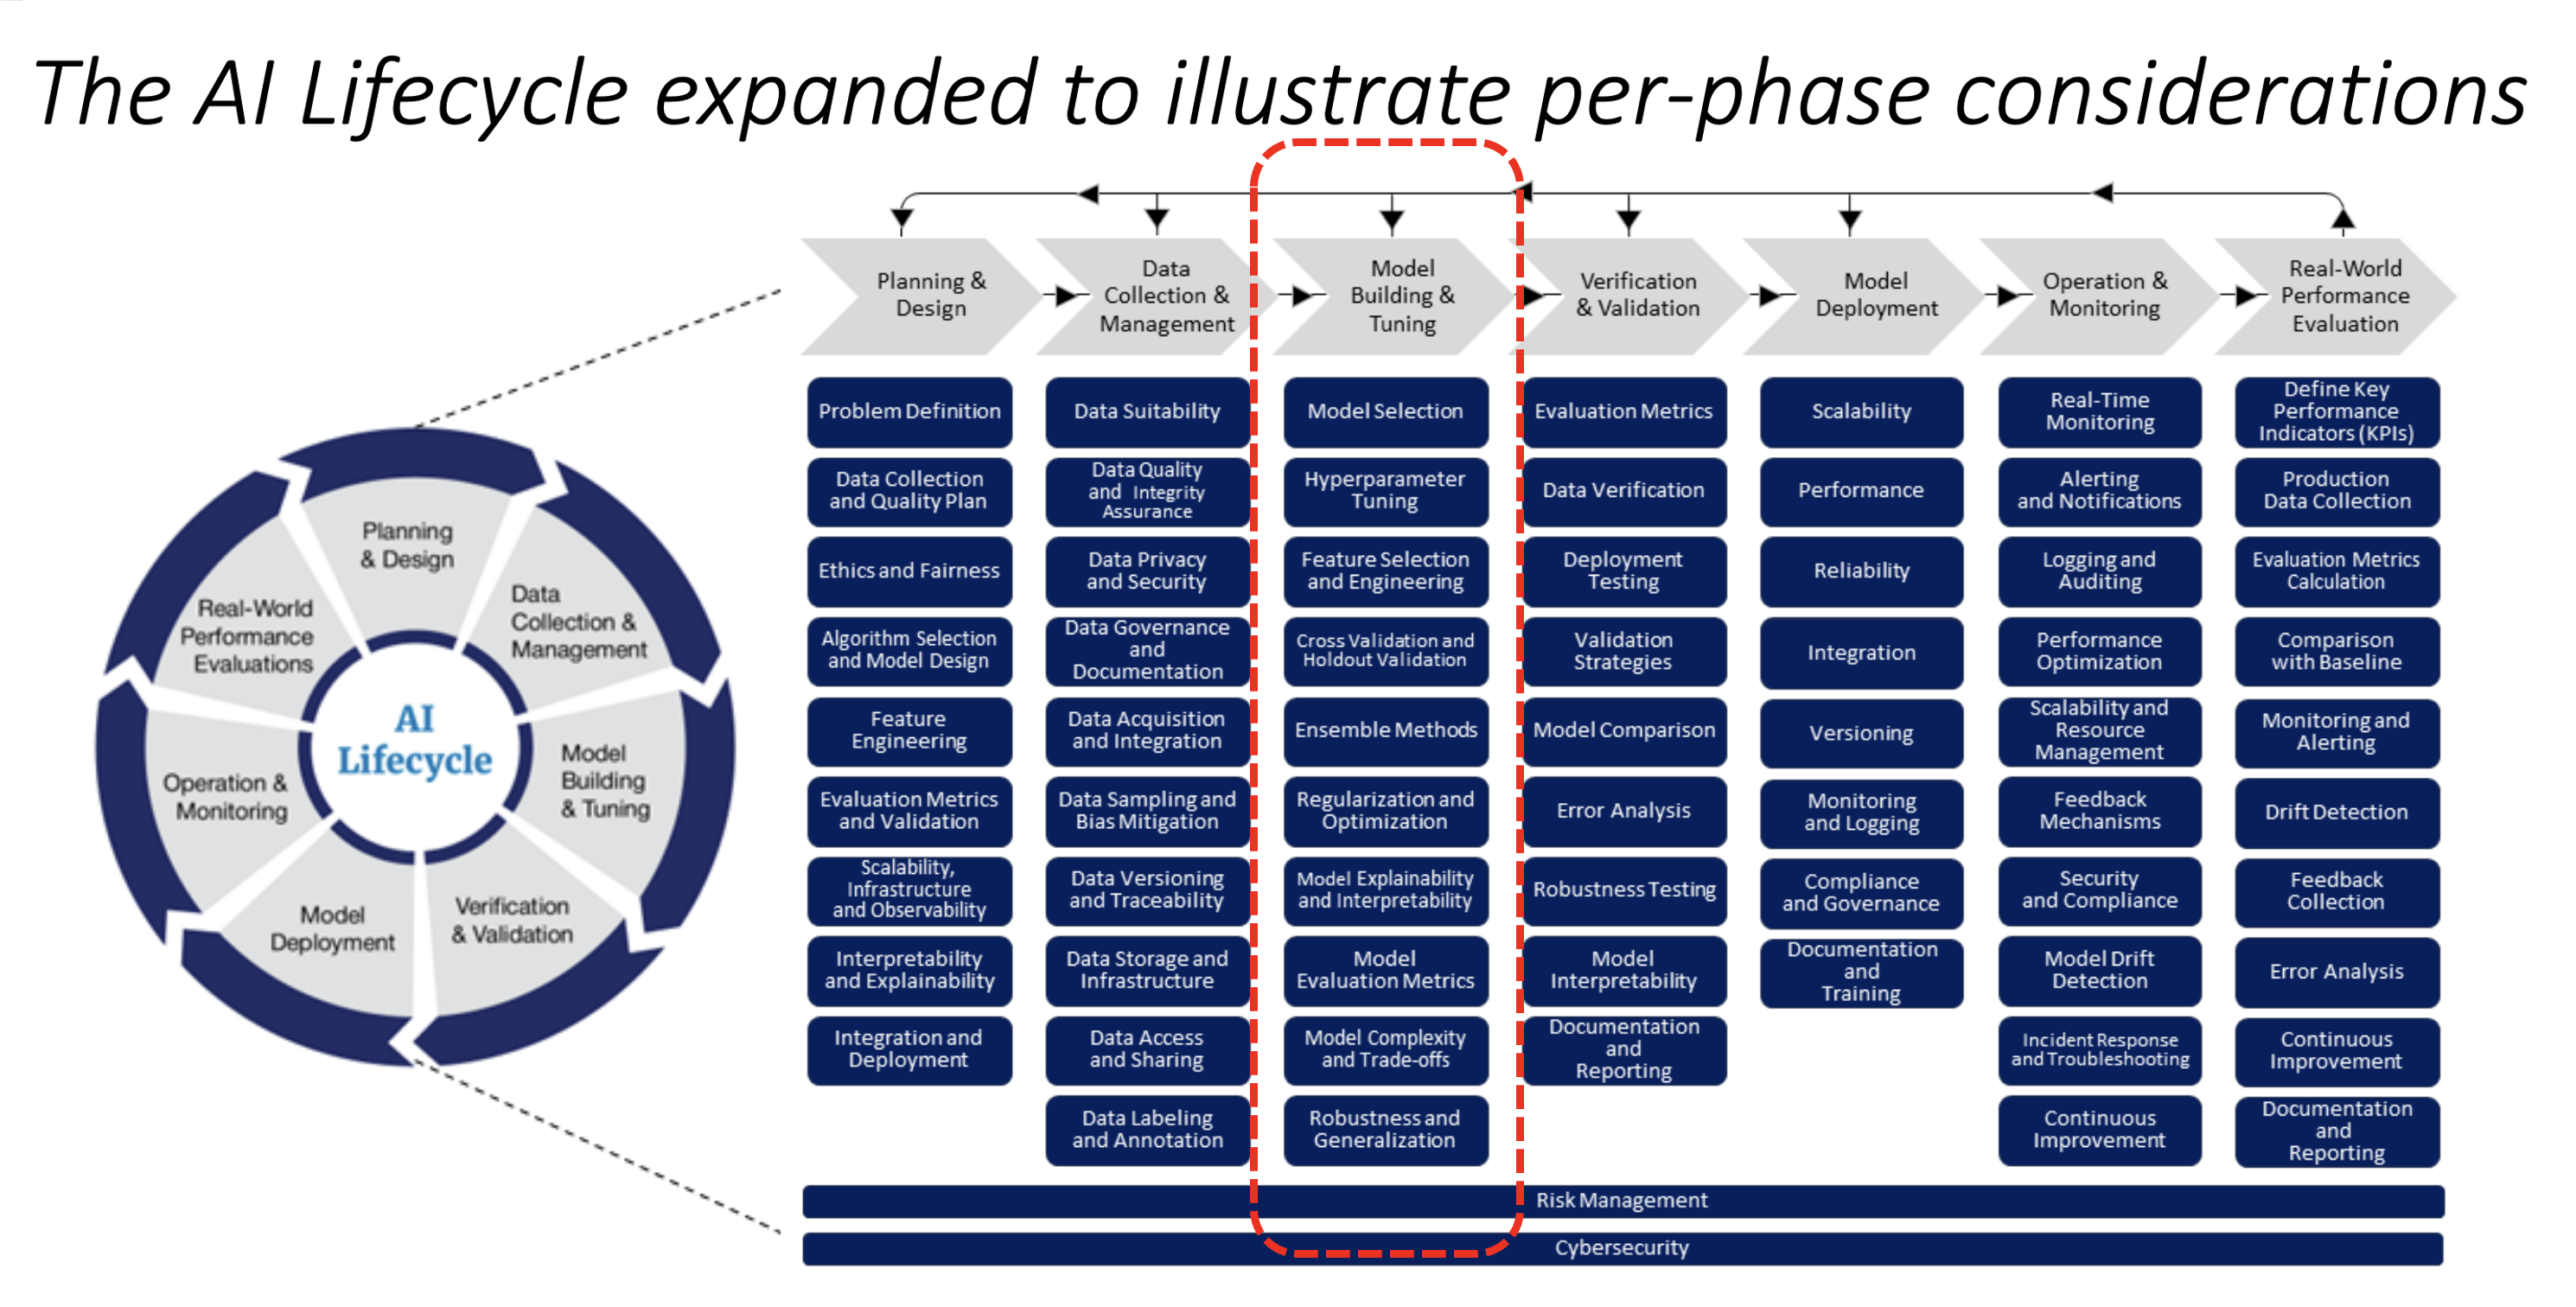

**While we start, please run the cell below. It will set up the environment for you**

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import data_table, output
# data_table.enable_dataframe_formatter()
# output.no_vertical_scroll()

# Download data for he project
!wget -rq -O diabetes_data.csv https://raw.githubusercontent.com/mandar-karhade/Medcon2024/main/Data%20files/diabetes_data.csv
!wget -rq -O diabetes_dataset00.csv https://raw.githubusercontent.com/mandar-karhade/Medcon2024/main/Data%20files/diabetes_dataset00.csv
!wget -rq -O requirements.txt https://raw.githubusercontent.com/mandar-karhade/Medcon2024/main/requirements.txt

# Install all project dependencies
!python -m pip install -q mlflow
!pip install -q --no-deps -r  requirements.txt

# Setting up environment


### Importing all libraries

In [ ]:
# System and Warnings
import warnings
warnings.filterwarnings('ignore')

# Core Data Science Libraries
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import missingno as msno

# Formatting and Display
from tabulate import tabulate

# Scikit-learn Imports
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    train_test_split,
    learning_curve,
    ShuffleSplit
)
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
from sklearn.preprocessing import StandardScaler

# Scikit-learn Models
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression
)
from sklearn.ensemble import (
    AdaBoostClassifier,
    RandomForestClassifier,
    RandomForestRegressor
)
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import (
    DecisionTreeClassifier,
    export_graphviz
)

# Additional ML Tools
import shap
import pydotplus
from ydata_profiling import ProfileReport

### Understanding the data


In [ ]:
data = pd.read_csv('diabetes_data.csv')

# Understanding how the data looks
display(data.head(n=10))
display('-'*100)

# How large is the data?
display(f'The data has {data.shape[1]} columns, and {data.shape[0]} rows')
display('-'*100)

# What are the columns in the data
display(f'Column names: {", ".join(list(data.columns))}')
display('-'*100)

# what is the format of data
display(pd.DataFrame({"column-name": data.columns,
              "non-nulls": len(data)-data.isnull().sum().values,
              "nulls": data.isnull().sum().values,
              "type": data.dtypes.values}))

In [ ]:
profile = ProfileReport(data,
                        title="Profiling Report",
                        correlations=None,
                        interactions = None,
                        missing_diagrams={
                            "heatmap": False,
                            "bar" : False,
                            "matrix" : False
                            }
                        )
profile.to_notebook_iframe()
profile.to_file('data profile before cleaning.html')

### Defining the problem/s with the data

**We have a missingness problem**

Blood Pressure, Skin thickness, Insuling levels, BMI, Glucose levels, and Age of ZERO are incompatible with life! That means we have a problem.

We have to fix it -

**We have a few options**
*   We can check which patients did we have the least data on -
*   We can check if the missingness is real and then decide if we want to -
  - remove those observations
  - remove those features (variables)
  - replace/impute those variables

---




**Fixing ZERO and Missing values**
* First, we will replace all zeros to missing values**
* We have some good packages to investigate missingness (and I am lazy ;) )

In [ ]:
# missing data has been either marked as missing or has the value of 0 in our case. We need to clean both up
data_cleaned = data.copy()
for i in ['BloodPressure','SkinThickness','Insulin','BMI','Glucose','Age']:
  data_cleaned[i].replace(0, np.nan, inplace=True)

# Lets find percent missingness in the data for each variable
missingness_sorted = sorted(pd.DataFrame(data_cleaned.isna().sum()).to_dict()[0].items(), key=lambda x: -x[1])
list(map(lambda x: (x[0], round(x[1]/data_cleaned.shape[0]*100, 2)), missingness_sorted))

## Decision time about data!

* Insulin missing for 48.7% observations was heartbreaking
* Skin thickness was also missing for approximately 30% observations
* Clinically I hate to see Insulin missing for a diabetes dataset but thats life!

**We are keeping Insulin**

---

### Imputing missing values

In [ ]:
# imputing all missing values with mean fore all columns
simple_imputed_data = data_cleaned.copy()
for i in ['BloodPressure','SkinThickness','Insulin','BMI','Glucose','Age']:
  # Start the imputer engine and tell it that missing values are noted by NaN values and it has to use the 'mean' of all other values to fill in as a strategy.
  imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

  # Input the real data for each column to the imputer engine so that it can calculate what needs to be imputed.
  imputer =  imputer.fit(simple_imputed_data[[i]].values)

  # Replace the old columne with the new column of imputed NaN with mean.
  simple_imputed_data[i] = imputer.transform(simple_imputed_data[[i]].values)



# Lets see the difference between original data and the new data

print('Original data with Zeros')
display(data.head())
print('Original data with suspected zeros replaced with NaN')
display(data.head())
print('Imputed data with NaN replaced with mean')
display(simple_imputed_data.head())


# Lets rerun profile report again
profile = ProfileReport(simple_imputed_data,
                        title="Profiling Report",
                        correlations=None,
                        interactions = None,
                        missing_diagrams={
                            "heatmap": False,
                            "bar" : False,
                            "matrix" : False
                            }
                        )
profile.to_notebook_iframe()
profile.to_file('data profile after simple imputation.html')


### Imputations are not simple

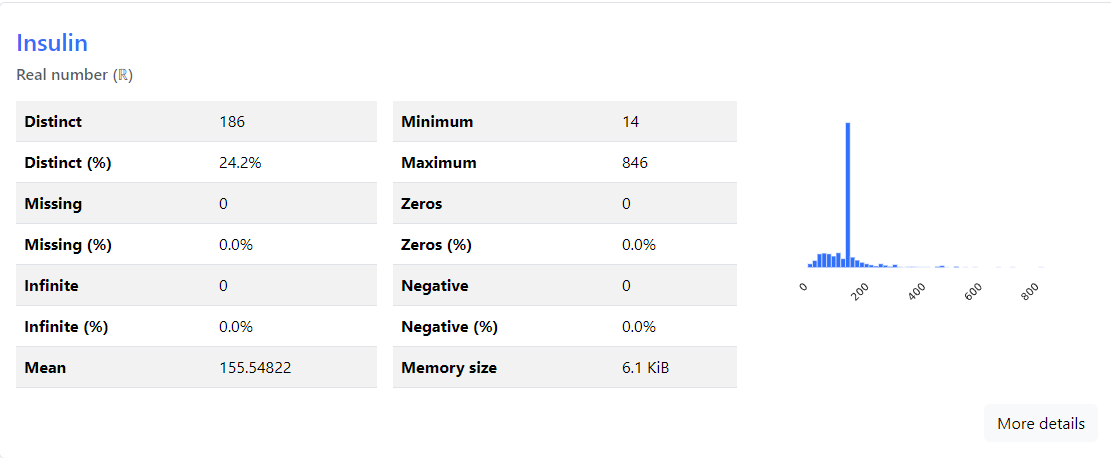

We need some way to use a better strategy.

---

### Not all missingness cleanup techniques are the same

Mean substitution solved missingness but created a ridiculous distribution!

We need a better way to fix missingness.

**A few options available for missingness imputation methods:**

1. Statistical Imputation:
  - Mean/Median/Mode
    * Simplest approach
    * Replace missing values with central tendency
    * Drawback: Reduces variance, ignores relationships

  - Random Sampling
    * Samples from observed values
    * Maintains distribution
    * Drawback: Ignores feature relationships

2. Advanced Statistical Methods:
  - Multiple Imputation
    * Creates multiple complete datasets
    * Combines results for uncertainty estimation
    * Better handles uncertainty than single imputation

  - Hot-Deck
    * Borrows values from similar records
    * Preserves relationships between variables
    * Good for categorical data

3. Model-Based:
  - KNN Imputation
    * Uses k nearest neighbors
    * Good for maintaining relationships
    * Sensitive to k value choice

  - Regression Imputation
    * Predicts missing values using other features
    * Preserves relationships
    * Can overfit/underestimate variance

4. Modern Approaches:
  - MICE (Multiple Imputation by Chained Equations)
    * Iterative approach using multiple models
    * Handles different variable types
    * Preserves relationships between features

  - MissForest
    * Random forest based imputation
    * Handles mixed-type data
    * Computationally intensive but accurate

5. Deep Learning:
  - Denoising Autoencoders
    * Neural network based
    * Good for complex patterns
    * Requires large datasets

6. Time Series Specific:
  - Forward/Backward Fill
    * Carries last/next known value
    * Good for temporal data
    * Assumes temporal consistency

7. Special Cases:
  - Indicator Method
    * Adds binary column for missingness
    * Preserves information about missing pattern
    * Used alongside other methods


### Not all missingess is same. Choose the best technique for the missingness you encounter

Choice factors:
  - Missing data mechanism (MCAR, MAR, MNAR)
    * MCAR : Missing Completely At Random
    * MAR : Missing at random (Missingness depends on the observed data)
    * MNAR : Missing not at random
  - Data type (numerical/categorical)
  - Computational resources
  - Required accuracy
  - Dataset size






---

Lets try IterativeImputer imputer. This time we will use other columns to inform value at the missing observation.


IterativeImputer (also known as MICE - Multiple Imputation by Chained Equations) works through an iterative process. Let me explain:

Core Mechanism:
1. Initial step:
- Fills missing values with simple strategy (mean/median)
- Creates starting point for iterations

2. Iterative Process:
- For each feature with missing values:
  * Uses all other features as predictors
  * Treats current feature as target
  * Fits a regression model
  * Predicts and updates missing values
- Repeats this cycle multiple times until convergence

Example:
```python
# Dataset with 3 features: A, B, C
# Step 1: Initialize with mean
A: [1, ?, 3] → [1, 2, 3]
B: [4, 5, ?] → [4, 5, 4.5]
C: [?, 8, 9] → [8.5, 8, 9]

# Step 2: First iteration
# Predict A using B and C
A = model(B, C)
# Predict B using A and C
B = model(A, C)
# Predict C using A and B
C = model(A, B)
```

Key Features:
1. Model flexibility:
   - Can use various estimators (LinearRegression, RandomForest, etc.)
   - Default is BayesianRidge

2. Handles dependencies:
   - Considers relationships between features
   - Better than simple imputation methods

3. Parameters:
   - max_iter: Maximum iterations
   - n_nearest_features: Limit features used for prediction
   - imputation_order: Order of imputation ('random', 'ascending', etc.)

Advantages:
- Preserves feature relationships
- More accurate than simple methods
- Handles different variable types

Disadvantages:
- Computationally intensive
- May not converge in some cases
- Requires sufficient non-missing data


We need to first remove the outcome from the data so that we dont impute using the outcome!

---

### Lets clean up missing data using the multiple imputations strategy



In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Lets create a new copy of the cleaned data (the one with the NaNs)
multi_imputed_data = data_cleaned.copy()

# Lets remove the influence of the outcome from the imputations - otherwise we are fitting the imputed values based on the outcome. This is information leakage
multi_imputed_data_outcome = multi_imputed_data[['Outcome']]
multi_imputed_data.drop(columns = ['Outcome'], inplace=True)

# Lets impute
imputer = IterativeImputer(missing_values=np.nan, max_iter=10, random_state=0)
imputer.fit(multi_imputed_data.values)
multi_imputed_data = pd.DataFrame(imputer.transform(multi_imputed_data), columns=multi_imputed_data.columns)

# Putting togetherFinal dataframe by adding back the outcomes
Finaldata = pd.concat([multi_imputed_data, multi_imputed_data_outcome], axis = 1)
Finaldata.head()

# Lets rerun profile report
profile = ProfileReport(Finaldata,
                        title="Profiling Report",
                        correlations=None,
                        interactions = None,
                        missing_diagrams={
                            "heatmap": False,
                            "bar" : False,
                            "matrix" : False
                            }
                        )
profile.to_notebook_iframe()
profile.to_file('data profile after multiple imputation.html.html')

**Reasonable post-imputation results**
That resultant distribution looks reasonable.! We can move to the next step. Lets save the data to build a machine learning model

In [ ]:
# Lets save the imputed data

Finaldata.to_csv('diabetes_data_imputed.csv', index=False)

# Building a Model

#### Helper functions.
Following cell contains a few helper funtions to keep our future code clean.

In [ ]:
# Helper functions to conduct our analysis


def print_nice_table(df, max_rows=None, max_cols=None):
    """
    Print a pandas DataFrame in a nice tabular format.

    :param df: pandas DataFrame to print
    :param max_rows: maximum number of rows to display (None for all)
    :param max_cols: maximum number of columns to display (None for all)
    """
    # Set pandas options
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.expand_frame_repr', False)

    # Slice the DataFrame if max_rows or max_cols is specified
    if max_rows is not None:
        df = df.head(max_rows)
    if max_cols is not None:
        df = df.iloc[:, :max_cols]

    # Convert DataFrame to tabulate format
    table = tabulate(df, headers='keys', tablefmt='pretty', showindex=True)

    # Print the table
    print(table)

    # Reset pandas options
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.expand_frame_repr')

def print_confusion_matrix(cm):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return plt

def print_feature_importance(X, importances_, model=None):
    """Print feature importance using both traditional and SHAP methods

    Args:
        X: Feature dataset
        importances_: Feature importance scores from model
        model: Optional trained model for SHAP values
    """
    # Traditional feature importance
    import matplotlib.pyplot as plt
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': np.round(importances_, decimals=4)
    }).sort_values('importance', ascending=False)

    print("\nTraditional Feature Importance:")
    print_nice_table(feature_importance)

    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x='importance', y='feature', data=feature_importance)

    for i, v in enumerate(feature_importance['importance']):
        ax.text(v, i, f' {v:.4f}', va='center')

    plt.title('Traditional Feature Importance')
    plt.tight_layout()
    plt.close()
    return plt



def plot_hyperparameter_effect_curves(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    the np.linspace argument is training data using 10% to 100% at each iteration to show the effect of one of the parameters (training sample size)
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")
    axes[0].set_ylim(0,1)


    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt



def plot_waterfall_shap(model, X, observation):
    """
    Create SHAP visualizations for the model
    """
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    print(shap.plots.waterfall(shap_values[observation], max_display=14))

def plot_beeswarm_shap(model, X):
    """
    Create SHAP visualizations for the model
    """
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    print(shap.plots.beeswarm(shap_values, max_display=14))


def plot_learning_curve_hyperparameters(
    X,                          # Feature dataset
    y,                          # Target variable
    hyperparameter,             # Name of hyperparameter to test
    param_range,                # Range of values to test for the hyperparameter
    n_estimators=100,           # Number of trees in the forest
    test_size=0.2,              # 20% of data used for testing
    random_state=42             # Seed for reproducibility
    ):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    train_scores = []
    test_scores = []

    for param_value in param_range:
        rf_params = {
            'n_estimators': n_estimators,
            'random_state': random_state,
            hyperparameter: param_value
        }
        rf = RandomForestClassifier(**rf_params)
        rf.fit(X_train, y_train)

        train_scores.append(accuracy_score(y_train, rf.predict(X_train)))
        test_scores.append(accuracy_score(y_test, rf.predict(X_test)))

    plt.figure(figsize=(10, 6))
    plt.plot(param_range, train_scores, label='Training score')
    plt.plot(param_range, test_scores, label='Test score')
    plt.xlabel(f'{hyperparameter} value')
    plt.ylabel('Accuracy Score')
    plt.title(f'Learning Curve: Accuracy vs {hyperparameter}')
    plt.legend()
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

---

### First model: RandomForest

We have made an executive decision to present randomforest model that does the classification task as diabetic vs non-diabetic predictions.

**What is Random Forest model:**

#### Core Concepts:
1. Ensemble Method:
  - Combines multiple decision trees
  - Uses bagging (Bootstrap Aggregating)
  - Each tree votes for final prediction

2. Key Features:
  - Random Sample Selection (Bagging):
    * Each tree gets different data subset
    * Typically ~63.2% of data (1 - 1/e)
    * Remaining data used for OOB (Out-of-Bag) error

  - Feature Randomization:
    * Each split considers random feature subset
    * Default: sqrt(n_features) for classification
    * Default: n_features/3 for regression

3. Training Process:
```python
For each tree:
    1. Bootstrap sample from training data
    2. Grow tree:
        - At each node:
            * Select random feature subset
            * Find best split on these features
            * Split node
        - Continue until stopping criteria met
```

4. Prediction Process:
  - Classification: Majority vote
  - Regression: Mean prediction

#### Advantages:
1. Performance:
  - Handles non-linearity well
  - Good accuracy out-of-box
  - Less prone to overfitting

2. Robustness:
  - Handles missing values
  - Handles outliers
  - No scaling needed

3. Feature Importance:
  - Built-in feature importance
  - Gini importance/Mean decrease impurity
  - Permutation importance

#### Key Parameters:
```python
RandomForestClassifier(
    n_estimators=100,      # Number of trees
    max_depth=None,        # Maximum tree depth
    min_samples_split=2,   # Min samples for split
    min_samples_leaf=1,    # Min samples in leaf
    max_features='sqrt',   # Features per split
    bootstrap=True         # Use bagging
)
```

#### Limitations:
  - Black box nature
  - Memory intensive
  - Slower training than single models
  - May overfit with noisy data




### Lets build

Here's a markdown description of the key steps in the code:

1. **Data Loading and Exploration**
   - Load diabetes dataset from CSV
   - Display basic dataset information and sample rows

2. **Data Preparation**
   - Separate features (X) and target variable (Outcome)
   - Split data: 80% training, 20% testing (with random_state=42)

3. **Data Preprocessing**
   - Apply StandardScaler to normalize features
   - Fit scaler on training data
   - Transform both training and test data

4. **Model Training**
   - Initialize RandomForestClassifier (100 trees)
   - Train model on scaled training data

5. **Model Evaluation**
   - Generate predictions on test set
   - Calculate accuracy score
   - Create classification report with precision, recall, F1-score
   - Generate confusion matrix for visual analysis

6. **Model Interpretation**
   - Plot feature importance graph
   - Visualize single decision tree from forest
   - Export tree visualization as PNG

7. **Model Persistence**
   - Save trained model using joblib
   - Save as 'diabetes_prediction_model_rf_classifier.joblib'

In [ ]:
# Load the dataset (assuming we have a CSV file named 'diabetes_data.csv')
data = pd.read_csv('diabetes_data_imputed.csv')

# Display basic information about the dataset
display("Sample data:")
print_nice_table(data, max_rows=20)

# Separate features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(
                    n_estimators=100,      # Number of trees
                    max_depth=None,        # Maximum tree depth
                    min_samples_split=20,   # Min samples for split
                    min_samples_leaf=20,    # Min samples in leaf
                    max_features='sqrt',   # Features per split
                    bootstrap=False         # Use bagging
                )
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
display(f"Accuracy: {accuracy:.2f}")

display("Classification Report:")
report = classification_report(y_test, y_pred, output_dict = True)
df_report = pd.DataFrame(report)
df_report = df_report.round(3)
print_nice_table(df_report)
display("-"*100)


# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=rf_classifier.classes_)
plt = print_confusion_matrix(cm)
plt.show()
plt.close()


# Feature importance
plt = print_feature_importance(X, rf_classifier.feature_importances_)
plt.show()
plt.close()

# Print the decision tree using random_forest classifier
estimator = rf_classifier.estimators_[0]
export_graphviz(estimator, out_file='tree.dot',
                feature_names = X.columns,
                class_names = ['non diabetic','diabetic'],
                rounded = True,
                proportion = False,
                precision = 2,
                filled = True)
graph = pydotplus.graph_from_dot_file('tree.dot')
graph_attrs = {
    'dpi': '90',
    'fontsize': '10'
}
for attr, value in graph_attrs.items():
    getattr(graph, f'set_{attr}')(value)
graph.write_png('tree.png')
display(Image(filename='tree.png'))


# Save the model
import joblib
joblib.dump(rf_classifier, 'diabetes_prediction_model_rf_classifier.joblib')
display("Model saved as 'diabetes_prediction_model_rf_classifier.joblib'")
display("Experiment completed successfully!")

### Accuracy
- Simply the ratio of correct predictions to total predictions
- Works well for balanced datasets
- Formula:
(True Positives + True Negatives) / Total Samples

### Precision
- The ratio of correct positive predictions to total positive predictions
- Answers: "Of all cases we predicted as positive, how many were actually positive?"
- Important when false positives are costly
- Formula:
True Positives / (True Positives + False Positives)

### Recall (also called Sensitivity or True Positive Rate)
- The ratio of correct positive predictions to all actual positives
- Answers: "Of all actual positive cases, how many did we catch?"
- Important when false negatives are costly
- Formula:
True Positives / (True Positives + False Negatives)

### F1 Score
- Harmonic mean of Precision and Recall
- Provides a single score that balances both precision and recall
- Formula:
2 * (Precision * Recall) / (Precision + Recall)

### Macro Average
- Average of metrics calculated independently for each class
- Treats all classes equally regardless of their size
- Better when you care equally about all classes, even rare ones
- Formula:
(metric_class1 + metric_class2 + ... + metric_classN) / N

### Weighted Average
- Aggregates the contributions of all classes to compute the average metric
- Treats each individual classification equally
- Better when dataset is imbalanced
- Dominated by performance on common classes
- Formula:
Calculated by counting total true positives, false negatives, etc. across all classes

---

### Example Interpretation:
For a medical diagnosis model:
- High Precision:
If your use case requires about few false alarms (false positives) then the high precision is the statistic to optimize

- High Recall:
If your use case is a screening method in which you do not want missed cases (false negatives) then optimize it for High recall

- High Accuracy:
If you need Good overall performance with high recall and precision. But know that it may be misleading with imbalanced data where the positive samples are too low or high in proportion.  

- High F1:
If you need both a balance of high precision and high recall then a good balance between false alarms and missed cases is a mean of both. But know that high F1 is restricted to the test data statistics. This may not translate into the real life performance.  




# Deeper dive on each decision

### How do we choose the algorithm
- The decision about what task is being completed is made before the experiment starts
- The Algorithm and the variations of algorithms are decided as more data is understood
- The choice of algorithm is dictated by the expected acuracy

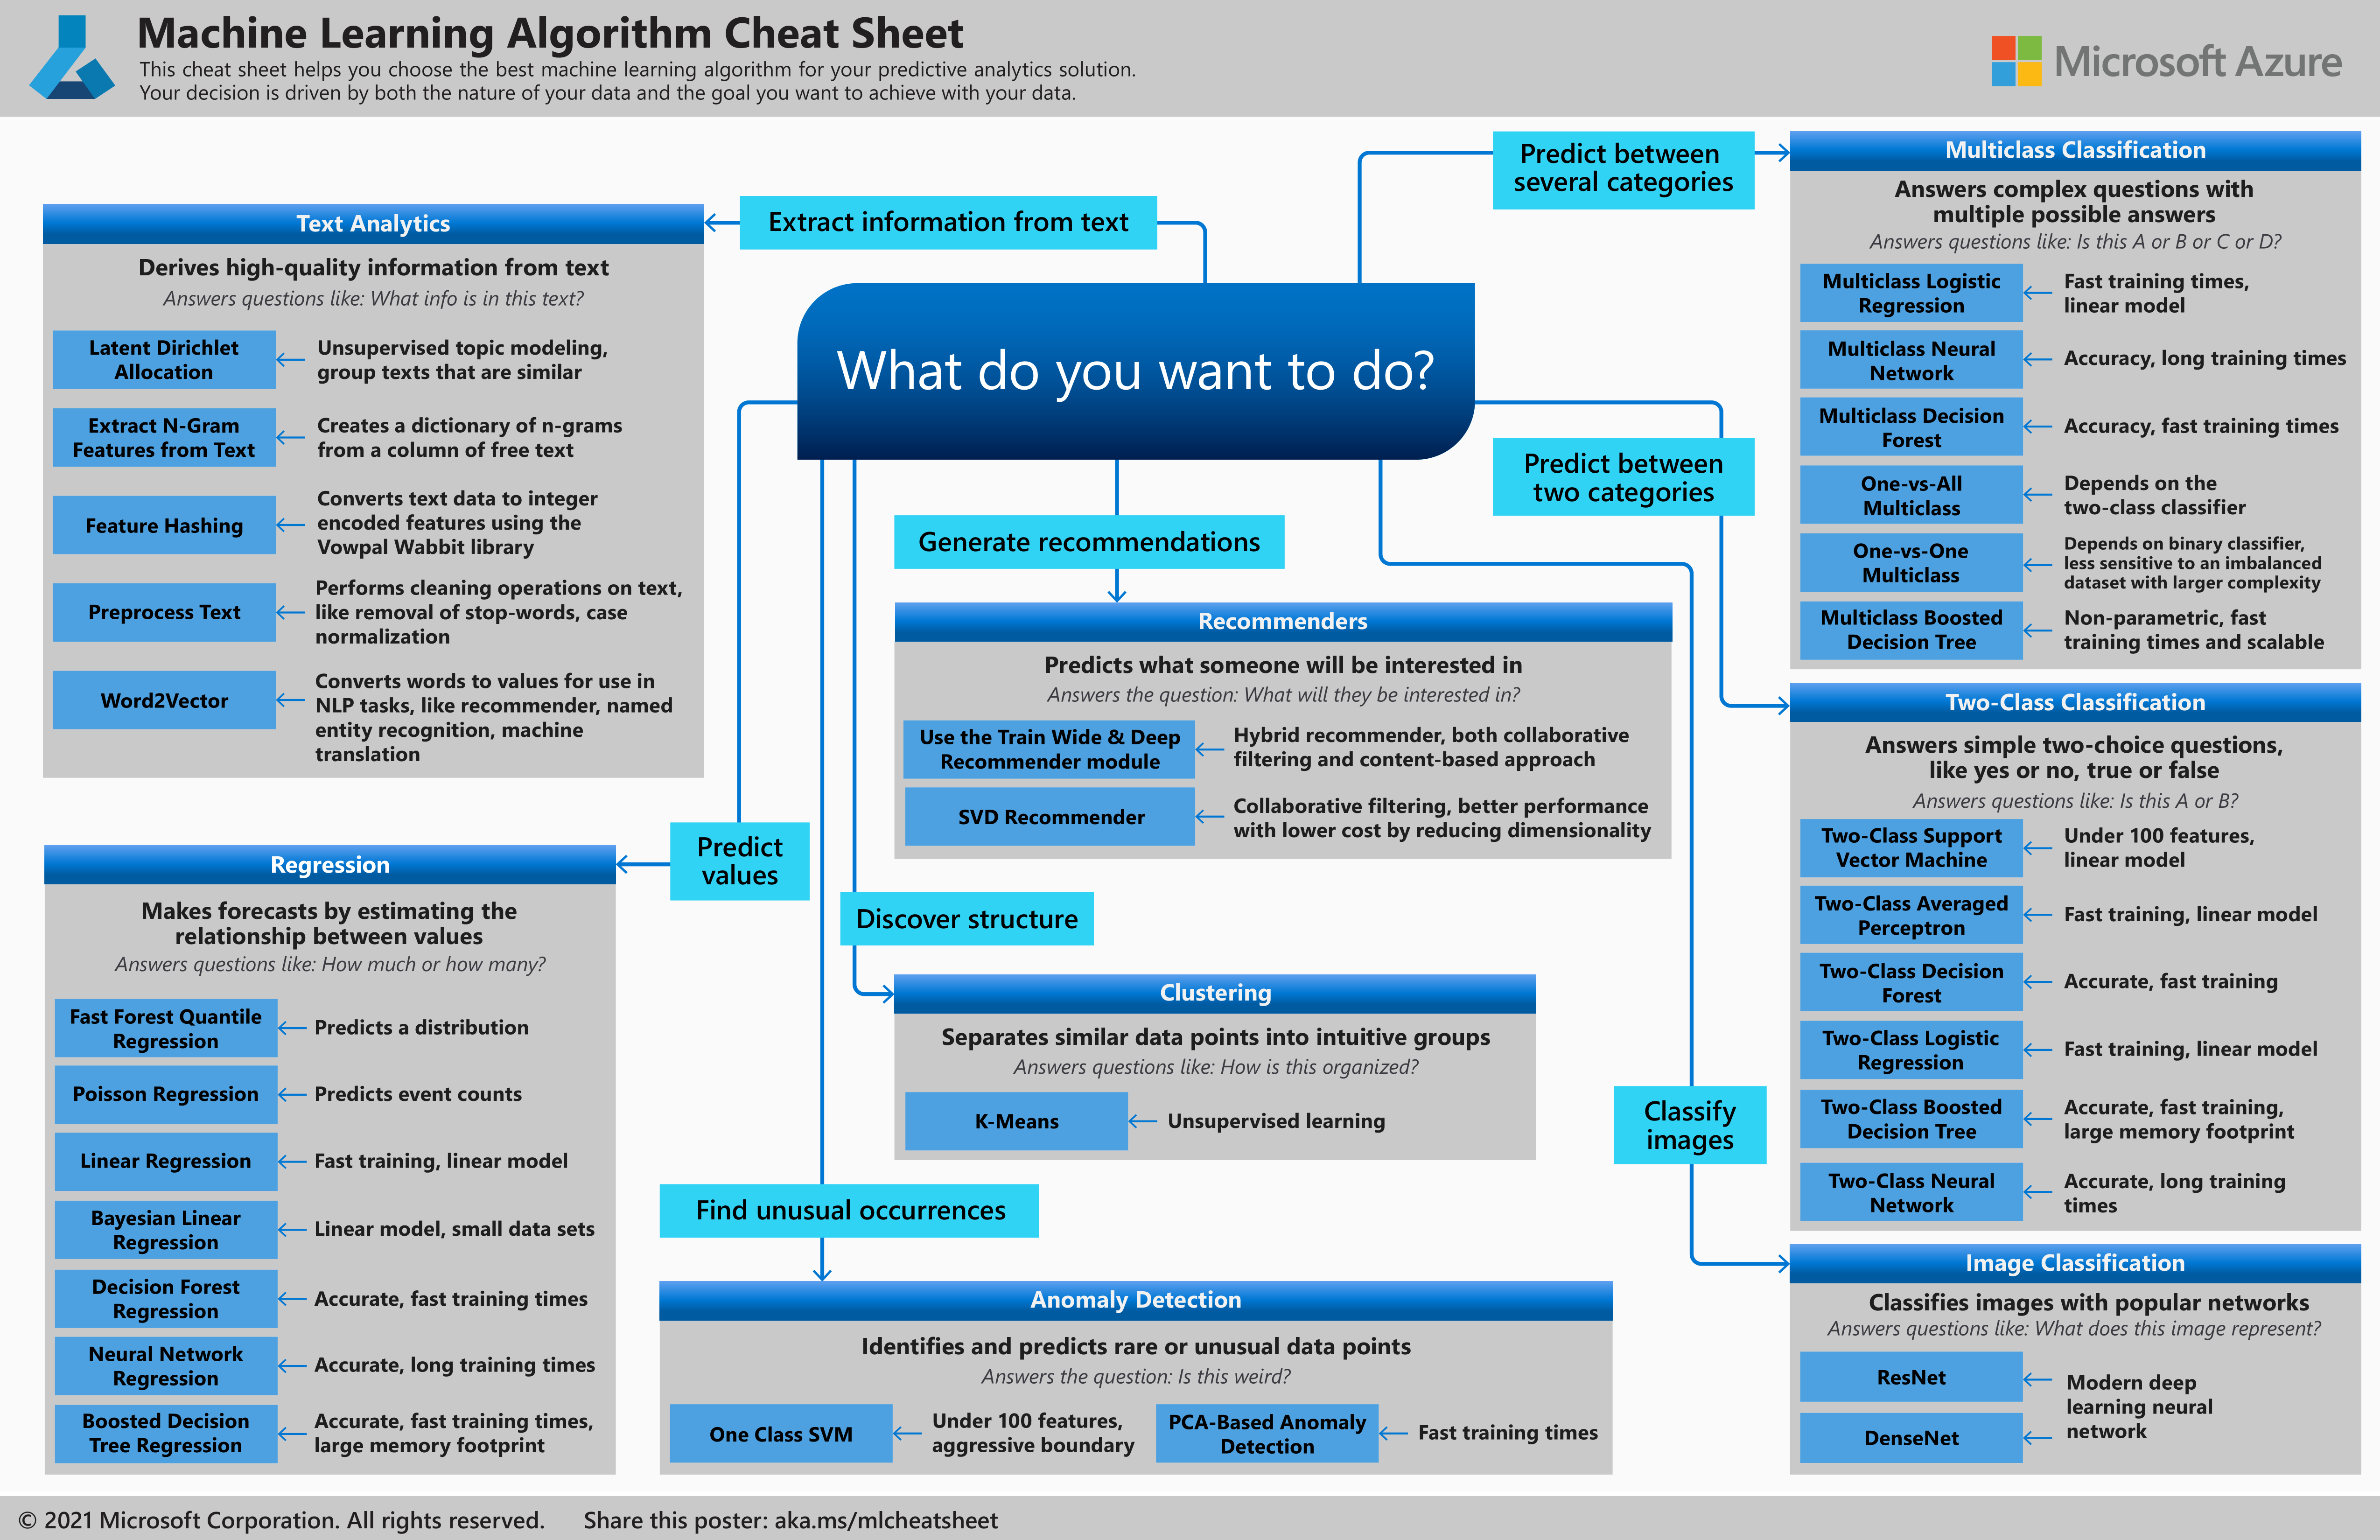


### Comparing performance of different classifiers


In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

# Load the dataset (assuming we have a CSV file named 'diabetes_data.csv')
data = pd.read_csv('diabetes_data_imputed.csv')

# Display basic information about the dataset
print("\nSample data:")
# print_nice_table(data, max_rows=20)

# Separate features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Define classifiers to evaluate
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'KNN': KNeighborsClassifier()
}

# Store results for comparison
results = []

# Loop through each classifier
for name, clf in classifiers.items():
    print(f"\n{'-'*20} {name} {'-'*20}")

    # Train the classifier
    clf.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = clf.predict(X_test_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nAccuracy: {accuracy:.2f}")

    # Classification Report
    print("\nClassification Report:")
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report)
    df_report = df_report.round(3)
    print_nice_table(df_report)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    plt = print_confusion_matrix(cm)
    plt.savefig(f'confusion_matrix_{name.lower().replace(" ", "_")}.png')
    plt.close()

    # Feature importance (for different types of classifiers)
    if hasattr(clf, 'feature_importances_'):
        # For tree-based models (Random Forest, Gradient Boosting)
        plt = print_feature_importance(X, clf.feature_importances_)
        plt.savefig(f'feature_importance_{name.lower().replace(" ", "_")}.png')
        plt.close()
    elif hasattr(clf, 'coef_'):
        # For linear models (Logistic Regression, Linear SVM)
        importances = np.abs(clf.coef_[0]) if clf.coef_.ndim == 2 else np.abs(clf.coef_)
        plt = print_feature_importance(X, importances)
        plt.savefig(f'feature_importance_{name.lower().replace(" ", "_")}.png')
        plt.close()
    else:
        # For models without direct feature importance (KNN, non-linear SVM)
        print(f"\nCalculating permutation importance for {name}...")
        result = permutation_importance(
            clf, X_test_scaled, y_test,
            n_repeats=10,
            random_state=42,
            n_jobs=-1
        )
        importances = result.importances_mean
        plt = print_feature_importance(X, importances)
        plt.savefig(f'feature_importance_{name.lower().replace(" ", "_")}.png')
        plt.close()

    # Save the model
    joblib.dump(clf, f'model_{name.lower().replace(" ", "_")}.joblib')
    # print(f"\nModel saved as 'model_{name.lower().replace(" ", "_")}.joblib'")

    # Store results for comparison
    results.append({
        'Classifier': name,
        'Accuracy': np.round(accuracy, decimals=3),
        'Precision': np.round(report['weighted avg']['precision'], decimals=3),
        'Recall': np.round(report['weighted avg']['recall'], decimals=3),
        'F1-Score': np.round(report['weighted avg']['f1-score'], decimals=3)
    })

# Display comparison of results
results_df = pd.DataFrame(results)
print(f"{'-'*100}\nModel Comparison:")
print_nice_table(results_df.sort_values('Accuracy', ascending=False))

print("\nAll experiments completed successfully!")

---
### How is the node split decision being made?

Earlier we saw RandomForestClassification. It is a decision tree algorithm where at each time a decision is made to split the nodes such that the randomness in the data decreases.

The randomness is calcuated using Gini Index (or Gini Impurity) is a measure used in decision trees to determine the quality of a split. Let me break it down:

Definition:
- Measures the probability of incorrect classification of a randomly chosen element
- Ranges from 0 (pure) to 1 (impure)
- Formula: G = 1 - Σ(pi²) where pi is proportion of class i

Example Calculation:
1. Pure Node (Best Case):
```python
# All samples belong to one class
Class A: 100%, Class B: 0%
Gini = 1 - (1² + 0²) = 0
```

2. Impure Node (Worst Case):
```python
# Equal split between classes
Class A: 50%, Class B: 50%
Gini = 1 - (0.5² + 0.5²) = 0.5
```

**Usage in Decision Trees:**
1. For each potential split:
   - Calculate weighted Gini for child nodes
   - Choose split with lowest weighted Gini

2. Example Split Decision:

```python
Parent Node: [60 A, 40 B] Gini = 0.48

Split 1:
- Left: [50 A, 10 B] Gini = 0.32
- Right: [10 A, 30 B] Gini = 0.42
Weighted Gini = (60/100 × 0.32) + (40/100 × 0.42) = 0.36

Split 2:
- Left: [30 A, 30 B] Gini = 0.50
- Right: [30 A, 10 B] Gini = 0.42
Weighted Gini = (60/100 × 0.50) + (40/100 × 0.42) = 0.47

→ Choose Split 1 (lower weighted Gini)
```

**Key Points:**
- Lower Gini = Better split
- Used during tree construction
- Similar to entropy but computationally simpler
- Favors larger partitions


---

### Is the model too complex or is overfit?

Visualizing decision boundaries helps us understand the difference between a model that's overfitting and one that's well-generalized. An overfit model creates complex, irregular boundaries that precisely wrap around training points, while a well-balanced model produces smoother, simpler boundaries that better capture the true underlying patterns in the data. This visual comparison makes it easier to recognize when a model is learning the noise rather than the signal.

To elaborate with examples:
1. Overfit boundary:
- Jagged, intricate patterns
- Curves around individual data points
- Likely performs poorly on new data

2. Well-balanced boundary:
- Smooth, clear separation
- General trends captured
- More likely to generalize well

#### Example of decision boundary

In [ ]:
# prompt: print decision boundary heatmap of the random forest. Use only BMI and Insulin as features

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming X and y are defined as in your previous code
# X = data.drop('Outcome', axis=1)
# y = data['Outcome']

# Select BMI and Insulin as features
X_subset = X[['Age', 'BMI']]

# Split the data
X_train_subset, X_test_subset, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled_subset = scaler.fit_transform(X_train_subset)
X_test_scaled_subset = scaler.transform(X_test_subset)


# Train a Random Forest Classifier with the subset of features
rf_classifier_subset = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_subset.fit(X_train_scaled_subset, y_train)


# Create the meshgrid
x_min, x_max = X_train_scaled_subset[:, 0].min() - 1, X_train_scaled_subset[:, 0].max() + 1
y_min, y_max = X_train_scaled_subset[:, 1].min() - 1, X_train_scaled_subset[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict on the meshgrid
Z = rf_classifier_subset.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_train_scaled_subset[:, 0], X_train_scaled_subset[:, 1], c=y_train, edgecolors='k')
plt.xlabel("AGE (scaled)")
plt.ylabel("BMI (scaled)")
plt.title("Decision Boundary Heatmap (AGE and BMI)")
plt.show()

#### Comparing decision boundaries for different algorithms

- to keep the interpretation simple, we will use only Age and BMI as input features.


In [ ]:
from matplotlib.colors import ListedColormap
from sklearn.pipeline import make_pipeline
from sklearn.inspection import DecisionBoundaryDisplay

names = [
    "Linear SVM", "QDA", "Naive Bayes", "Nearest Neighbors", "RBF SVM",
    "Gaussian Process", "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
]

classifiers = [
    SVC(kernel="linear", C=0.025, random_state=42),
    QuadraticDiscriminantAnalysis(),
    GaussianNB(),
    KNeighborsClassifier(3),
    SVC(gamma='auto', C=1, degree=1, random_state=22),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=42),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
]

# Data preparation
X = Finaldata[['Age', 'BMI']].to_numpy()
y = Finaldata['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Set up plot boundaries
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

# Color maps
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

# Plot input data separately
plt.figure(figsize=(8, 6))
plt.title("Input Data Distribution")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k", label='Training')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k", label='Test')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('Age')
plt.ylabel('BMI')
plt.legend()
plt.show()

print('\n\n')
display('Lets see how different model complexities represent different shapes of decision boundaries')
# Plot classifiers in 2 rows of 5
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for idx, (name, clf) in enumerate(zip(names, classifiers)):
    ax = axes[idx]
    ax.set_title(name)

    # Train and plot decision boundary
    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    DecisionBoundaryDisplay.from_estimator(
        clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
    )

    # Plot training points
    ax.scatter(
        X_train[:, 0], X_train[:, 1],
        c=y_train, cmap=cm_bright,
        edgecolors="k", s=20
    )

    # Plot testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1],
        c=y_test, cmap=cm_bright,
        edgecolors="k", alpha=0.6, s=20
    )

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

    # Add accuracy score
    ax.text(
        x_max - 0.3,
        y_min + 0.3,
        ("%.2f" % score).lstrip("0"),
        size=15,
        horizontalalignment="right",
    )

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

# Load the dataset (assuming we have a CSV file named 'diabetes_data.csv')
data = pd.read_csv('diabetes_data_imputed.csv')

# Display basic information about the dataset
print("\nSample data:")
# print_nice_table(data, max_rows=20)

# Separate features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Define classifiers to evaluate
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'KNN': KNeighborsClassifier()
}

# Store results for comparison
results = []

# Loop through each classifier
for name, clf in classifiers.items():
    print(f"\n{'-'*20} {name} {'-'*20}")

    # Train the classifier
    clf.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = clf.predict(X_test_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nAccuracy: {accuracy:.2f}")

    # Classification Report
    print("\nClassification Report:")
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report)
    df_report = df_report.round(3)
    print_nice_table(df_report)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    plt = print_confusion_matrix(cm)
    plt.savefig(f'confusion_matrix_{name.lower().replace(" ", "_")}.png')
    plt.close()

    # Feature importance (for different types of classifiers)
    if hasattr(clf, 'feature_importances_'):
        # For tree-based models (Random Forest, Gradient Boosting)
        plt = print_feature_importance(X, clf.feature_importances_)
        plt.savefig(f'feature_importance_{name.lower().replace(" ", "_")}.png')
        plt.close()
    elif hasattr(clf, 'coef_'):
        # For linear models (Logistic Regression, Linear SVM)
        importances = np.abs(clf.coef_[0]) if clf.coef_.ndim == 2 else np.abs(clf.coef_)
        plt = print_feature_importance(X, importances)
        plt.savefig(f'feature_importance_{name.lower().replace(" ", "_")}.png')
        plt.close()
    else:
        # For models without direct feature importance (KNN, non-linear SVM)
        print(f"\nCalculating permutation importance for {name}...")
        result = permutation_importance(
            clf, X_test_scaled, y_test,
            n_repeats=10,
            random_state=42,
            n_jobs=-1
        )
        importances = result.importances_mean
        plt = print_feature_importance(X, importances)
        plt.savefig(f'feature_importance_{name.lower().replace(" ", "_")}.png')
        plt.close()

    # Save the model
    joblib.dump(clf, f'model_{name.lower().replace(" ", "_")}.joblib')
    # print(f"\nModel saved as 'model_{name.lower().replace(" ", "_")}.joblib'")

    # Store results for comparison
    results.append({
        'Classifier': name,
        'Accuracy': np.round(accuracy, decimals=3),
        'Precision': np.round(report['weighted avg']['precision'], decimals=3),
        'Recall': np.round(report['weighted avg']['recall'], decimals=3),
        'F1-Score': np.round(report['weighted avg']['f1-score'], decimals=3)
    })

# Display comparison of results
results_df = pd.DataFrame(results)
print(f"{'-'*100}\nModel Comparison:")
print_nice_table(results_df.sort_values('Accuracy', ascending=False))

print("\nAll experiments completed successfully!")

---

### How do hyperparameters affect the model

#### max_deapth
- Controls how deep each tree can grow
- lower values = simpler trees

#### min_samples_split
- controls how large the node should be to allow split
- lower values = complex trees

#### min_samples_leaf
- controls maximum number of samples in each leaf
- higher the number = simpler tree

#### max_features
- controls how many number of features to look for to get the best split
- lower number = more random selection
- higher number = expensive calculation, slower model

#### bootstrap
- controls if the resampling should allow replacement

In [ ]:
# Load the dataset (assuming we have a CSV file named 'diabetes_data.csv')
data = pd.read_csv('diabetes_data_imputed.csv')

# Separate features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']


def plot_learning_curve_hyperparameters(X, y, hyperparameter, param_range, n_estimators=100, test_size=0.2, random_state=42):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    train_scores = []
    test_scores = []

    # Convert param_range to list for indexing
    param_list = list(param_range)

    print(f"Parameter values being tested: {param_list}")  # Debug print

    for param_value in param_list:
        rf_params = {
            'n_estimators': n_estimators,
            'random_state': random_state,
            hyperparameter: param_value
        }
        rf = RandomForestClassifier(**rf_params)
        rf.fit(X_train, y_train)

        train_score = accuracy_score(y_train, rf.predict(X_train))
        test_score = accuracy_score(y_test, rf.predict(X_test))

        train_scores.append(train_score)
        test_scores.append(test_score)


    plt.figure(figsize=(10, 6))

    if isinstance(param_list[0], (str, bool)):
        x_range = range(len(param_list))
        plt.plot(x_range, train_scores, 'o-', label='Training score')  # Added markers
        plt.plot(x_range, test_scores, 'o-', label='Test score')      # Added markers
        plt.xticks(x_range, param_list)
    else:
        plt.plot(param_list, train_scores, 'o-', label='Training score')  # Added markers
        plt.plot(param_list, test_scores, 'o-', label='Test score')      # Added markers

    plt.xlabel(f'{hyperparameter} value')
    plt.ylabel('Accuracy Score')
    plt.title(f'Learning Curve: Accuracy vs {hyperparameter}')
    plt.legend()
    plt.ylim(0, 1.2)
    plt.grid(True)
    plt.show()

plot_learning_curve_hyperparameters(X, y, 'max_depth', range(1, 10))
plot_learning_curve_hyperparameters(X, y, 'min_samples_split', range(2, 21))
plot_learning_curve_hyperparameters(X, y, 'min_samples_leaf', range(1, 21))
plot_learning_curve_hyperparameters(X, y, 'max_features', ['sqrt', 'log2'] + list(np.arange(0.1, 1.1, 0.1)))
plot_learning_curve_hyperparameters(X, y, 'bootstrap', [True, False])

### MultiClass problem Cluster F

---



Here is a quick example

In [ ]:
import pandas as pd
data = pd.read_csv('diabetes_dataset00.csv')
display(data.head())
display(data.shape)
# display(data.dtypes)
display(data.groupby(by='Target').size())


In [ ]:
# Multiclass Experiment

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler



def clean_data(file_path):
    # Load the data
    data = pd.read_csv(file_path)
    print("Original data shape:", data.shape)
    # print("\nOriginal data types:")
    # print(data.dtypes)
    original_dtypes = pd.DataFrame(data.dtypes, columns=['Original'])


    # Function to check if a column is numeric
    def is_numeric(col):
        try:
            pd.to_numeric(data[col], errors='raise')
            return True
        except ValueError:
            return False

    # Identify numeric and categorical columns
    numeric_columns = [col for col in data.columns if is_numeric(col)]
    categorical_columns = [col for col in data.columns if col not in numeric_columns]

    print("\nNumeric columns:", numeric_columns)
    print("\nCategorical columns:", categorical_columns)

    # Handle missing values
    numeric_imputer = SimpleImputer(strategy='mean')
    categorical_imputer = SimpleImputer(strategy='most_frequent')

    data[numeric_columns] = numeric_imputer.fit_transform(data[numeric_columns])
    data[categorical_columns] = categorical_imputer.fit_transform(data[categorical_columns])

    # Encode categorical variables
    le = LabelEncoder()
    for col in categorical_columns:
        data[col] = le.fit_transform(data[col].astype(str))

    # Scale numeric features
    scaler = StandardScaler()
    data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

    # print("\nCleaned data types:")
    # print(data.dtypes)
    final_dtypes = pd.DataFrame(data.dtypes, columns=['Cleaned'])
    dtype_comparison = pd.concat([original_dtypes, final_dtypes], axis=1)

    print("\nData Types Comparison:")
    print(dtype_comparison)

    # Create the cleaned file path in the same directory as the original file
    original_dir = os.path.dirname(file_path)
    original_filename = os.path.basename(file_path)
    cleaned_filename = 'cleaned_' + original_filename
    cleaned_file_path = os.path.join(original_dir, cleaned_filename)

    # Save the cleaned data
    data.to_csv(cleaned_file_path, index=False)
    print(f"\nCleaned data saved to {cleaned_file_path}")

    return data, cleaned_file_path



# Load the dataset (assuming we have a CSV file named 'multiclass_health_data.csv')
data, cleaned_file_path = clean_data('diabetes_dataset00.csv')



# Separate features and target
X = data.drop('Target', axis=1)  # Assuming 'HealthStatus' is the target column
y = data['Target']

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)
unique_classes = [str(cls) for cls in range(len(le.classes_))]
print("\nUnique classes:", unique_classes)



# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create and train the model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Create CV object
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train the model on the full training set
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=unique_classes))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=rf_classifier.classes_)
plt = print_confusion_matrix(cm)
plt.show()
plt.close()


# Feature importance
plt = print_feature_importance(X, rf_classifier.feature_importances_)
plt.show()
plt.close()

print("\nFeature importance plot has been saved as 'feature_importance_multiclass.png'")

print("\nMulticlass classification analysis completed successfully!")

#### Question
- In a multiclass classification, which groups are the most important?
  - Should we focus on the accuracy across all the groups, or
  - the majority groups, or
  - just minority groups?

### Feature Importance: Deeper dive Regression model.

- We will use that model to show the feature importance characteristics

In [ ]:
# Load the dataset (assuming we have a CSV file named 'diabetes_data.csv')
data = pd.read_csv('diabetes_data_imputed.csv')

# Display basic information about the dataset
print("\nSample data:")
# print_nice_table(data, max_rows=20)

# Separate features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Logistic Regression model (instead of Linear Regression)
linear_classifier = LogisticRegression()
linear_classifier.fit(X_train_scaled, y_train)

# Make predictions using the Logistic Regression model
y_pred = linear_classifier.predict(X_test_scaled) # Use linear_classifier for predictions

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.2f}")

print("\nClassification Report:")
report = classification_report(y_test, y_pred, output_dict = True)
df_report = pd.DataFrame(report)
df_report = df_report.round(3)
print_nice_table(df_report)
print("\n" + "-"*100)


# Create a confusion matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred, labels=linear_classifier.classes_)
plt = print_confusion_matrix(cm)
plt.close()


# Feature importance - using coefficients for Logistic Regression
# Note: This is different from feature importance in tree-based models
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.round(linear_classifier.coef_[0], decimals=4) # Access coefficients
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Logistic Regression Coefficients):")
print_nice_table(feature_importance)

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='importance', y='feature', data=feature_importance)

for i, v in enumerate(feature_importance['importance']):
    ax.text(v, i, f' {v:.4f}', va='center')

plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.tight_layout()
plt.savefig('feature_importance_logistic.png') # Save with a different name
plt.close()

# Save the model
import joblib
joblib.dump(linear_classifier, 'diabetes_prediction_model_linear_classifier.joblib')
print("\nModel saved as 'diabetes_prediction_model_linear_classifier.joblib'")

print("\nExperiment completed successfully!")

#### Feature importance visualized

In [ ]:
display('SHAP based feature importance')
plot_beeswarm_shap(linear_classifier, X)

# Feature importance
for i in (20, 22):
  print(f"{'-'*100} \nfeature importance for observation {i}")
  plt = plot_waterfall_shap(linear_classifier, X, i)

---

#### Local vs Global feature importance

**Local Feature Importance:**
- Explains predictions for individual instances
- Shows how each feature contributed to moving the prediction from baseline (average model output) to the final prediction
- Helps understand why a specific prediction was made
- Useful for:
  * Explaining decisions to stakeholders
  * Debugging model behavior on specific cases
  * Ensuring fairness for individual predictions

**Global Feature Importance:**
- Aggregates SHAP values across all instances
- Shows overall impact of features on model predictions
- Usually calculated by taking mean absolute SHAP values
- Helps understand model behavior at dataset level
- Useful for:
  * Feature selection
  * Model interpretation
  * Understanding general patterns


---

# Decisions at every point
- from cleaning the data to
- choosing the right model to
- what statistics do we report on or prioritize during the optimization
- We have not even evaluated the model yet!

There has to be a better way!  
---

# Automate, standardize, document: AutoML

**Only Carets, No sticks (PyCaret)**
- Lets make our life easier by an autoML platform
- Many alternatives to PyCaret exist

In [ ]:
# Import library
from pycaret.classification import *

# Set up data and project
clf = setup(Finaldata, target = 'Outcome', session_id=123, log_experiment=True, experiment_name='juice1', imputation_type='iterative')

### Selecting and evaluating the best model

In [ ]:
# Let the data choose the best model
best_model = clf.compare_models()

### Tune model

In [ ]:
bestest_model, tuner = tune_model(best_model, optimize = 'F1', return_tuner=True)

### Evaluate model

In [ ]:
# Let the caret show us the evaluation results for the best model
evaluate_model(bestest_model)

### Fairness of the model

In [ ]:
# Check fairness of the model based on Pregnancies (Is the model less accurate for Pregnant people?)
check_fairness(bestest_model, sensitive_features = ['Pregnancies'])

In [ ]:
check_fairness(bestest_model, sensitive_features = ['Age'])

### Document

- Data sourcing
- Manipulation
- Randomness control measures
- Algorithm
- Training and Testing parameters
- Tuning criteria and parameters
- Evaluation methods and criteria
- Evaluation results
- A complete Audit trail including all artifacts

In [ ]:
# Lets see what were the parameters of our bestest model
bestest_model.get_params()

In [ ]:
# Lets see what was our tuning pipeline.
tuner

# Preparing for the submission
Its a choreographed dance between the core technical team (AI/ML Data Scientists, software developers, QA Engineers, DevOps/MLOps people); supporting specialists like Clinical, Regulatory specialists; and Domain experts from medical, statistical, and to a lesser extent the human factors managers.

**Core Leadership:**
1. Clinical Lead/Medical Director
  - Provides medical oversight and clinical validation
  - Ensures clinical relevance and safety
  - Guides clinical requirements and use cases

2. Project Manager
  - Coordinates cross-functional teams
  - Manages regulatory compliance timeline
  - Ensures alignment between technical and clinical goals

**Core Technical Team:**
3. AI/ML Data Scientists
  - Design and develop AI/ML models
  - Handle data preprocessing and feature engineering
  - Implement model monitoring and maintenance

4. Software Engineers
  - Develop the software infrastructure
  - Create user interfaces and APIs
  - Implement integration with existing systems

5. Quality Engineers
  - Develop testing frameworks
  - Ensure code quality and documentation
  - Implement continuous integration/deployment

6. DevOps/MLOps Engineers
  - Set up development and deployment pipelines
  - Manage model versioning and deployment
  - Handle infrastructure and scaling

**Supporting Specialists:**
7. Clinical Data Scientists
  - Manage clinical data pipelines
  - Ensure data quality and compliance
  - Support model validation with clinical data

8. Regulatory Affairs Specialists
  - Guide regulatory strategy
  - Manage documentation for submissions
  - Ensure compliance with FDA/EU MDR requirements

9. Quality Assurance Manager
  - Oversees quality management system
  - Ensures compliance with ISO 13485
  - Manages risk management process

**Domain Experts:**
10. Medical Domain Experts
  - Provide clinical expertise
  - Support clinical validation
  - Guide clinical workflow integration

11. Biostatisticians/Epidemiologists
  - Design validation studies
  - Analyze model performance
  - Support clinical evidence generation

12. Human Factors Engineers
  - Design user interfaces
  - Conduct usability studies
  - Ensure safe human-AI interaction


### Where does it fit the Regulatory Framework?



There is no one place for these decisions but there are plenty of guidances.
We have always found Focus Group on Artificial Intelligence for Health (FG-AI4H) Good practices for health applications of machine learning: Considerations for manufacturers and regulators to be a good starting point.

Here is a reasonable layout of where current regulatory landscape is at
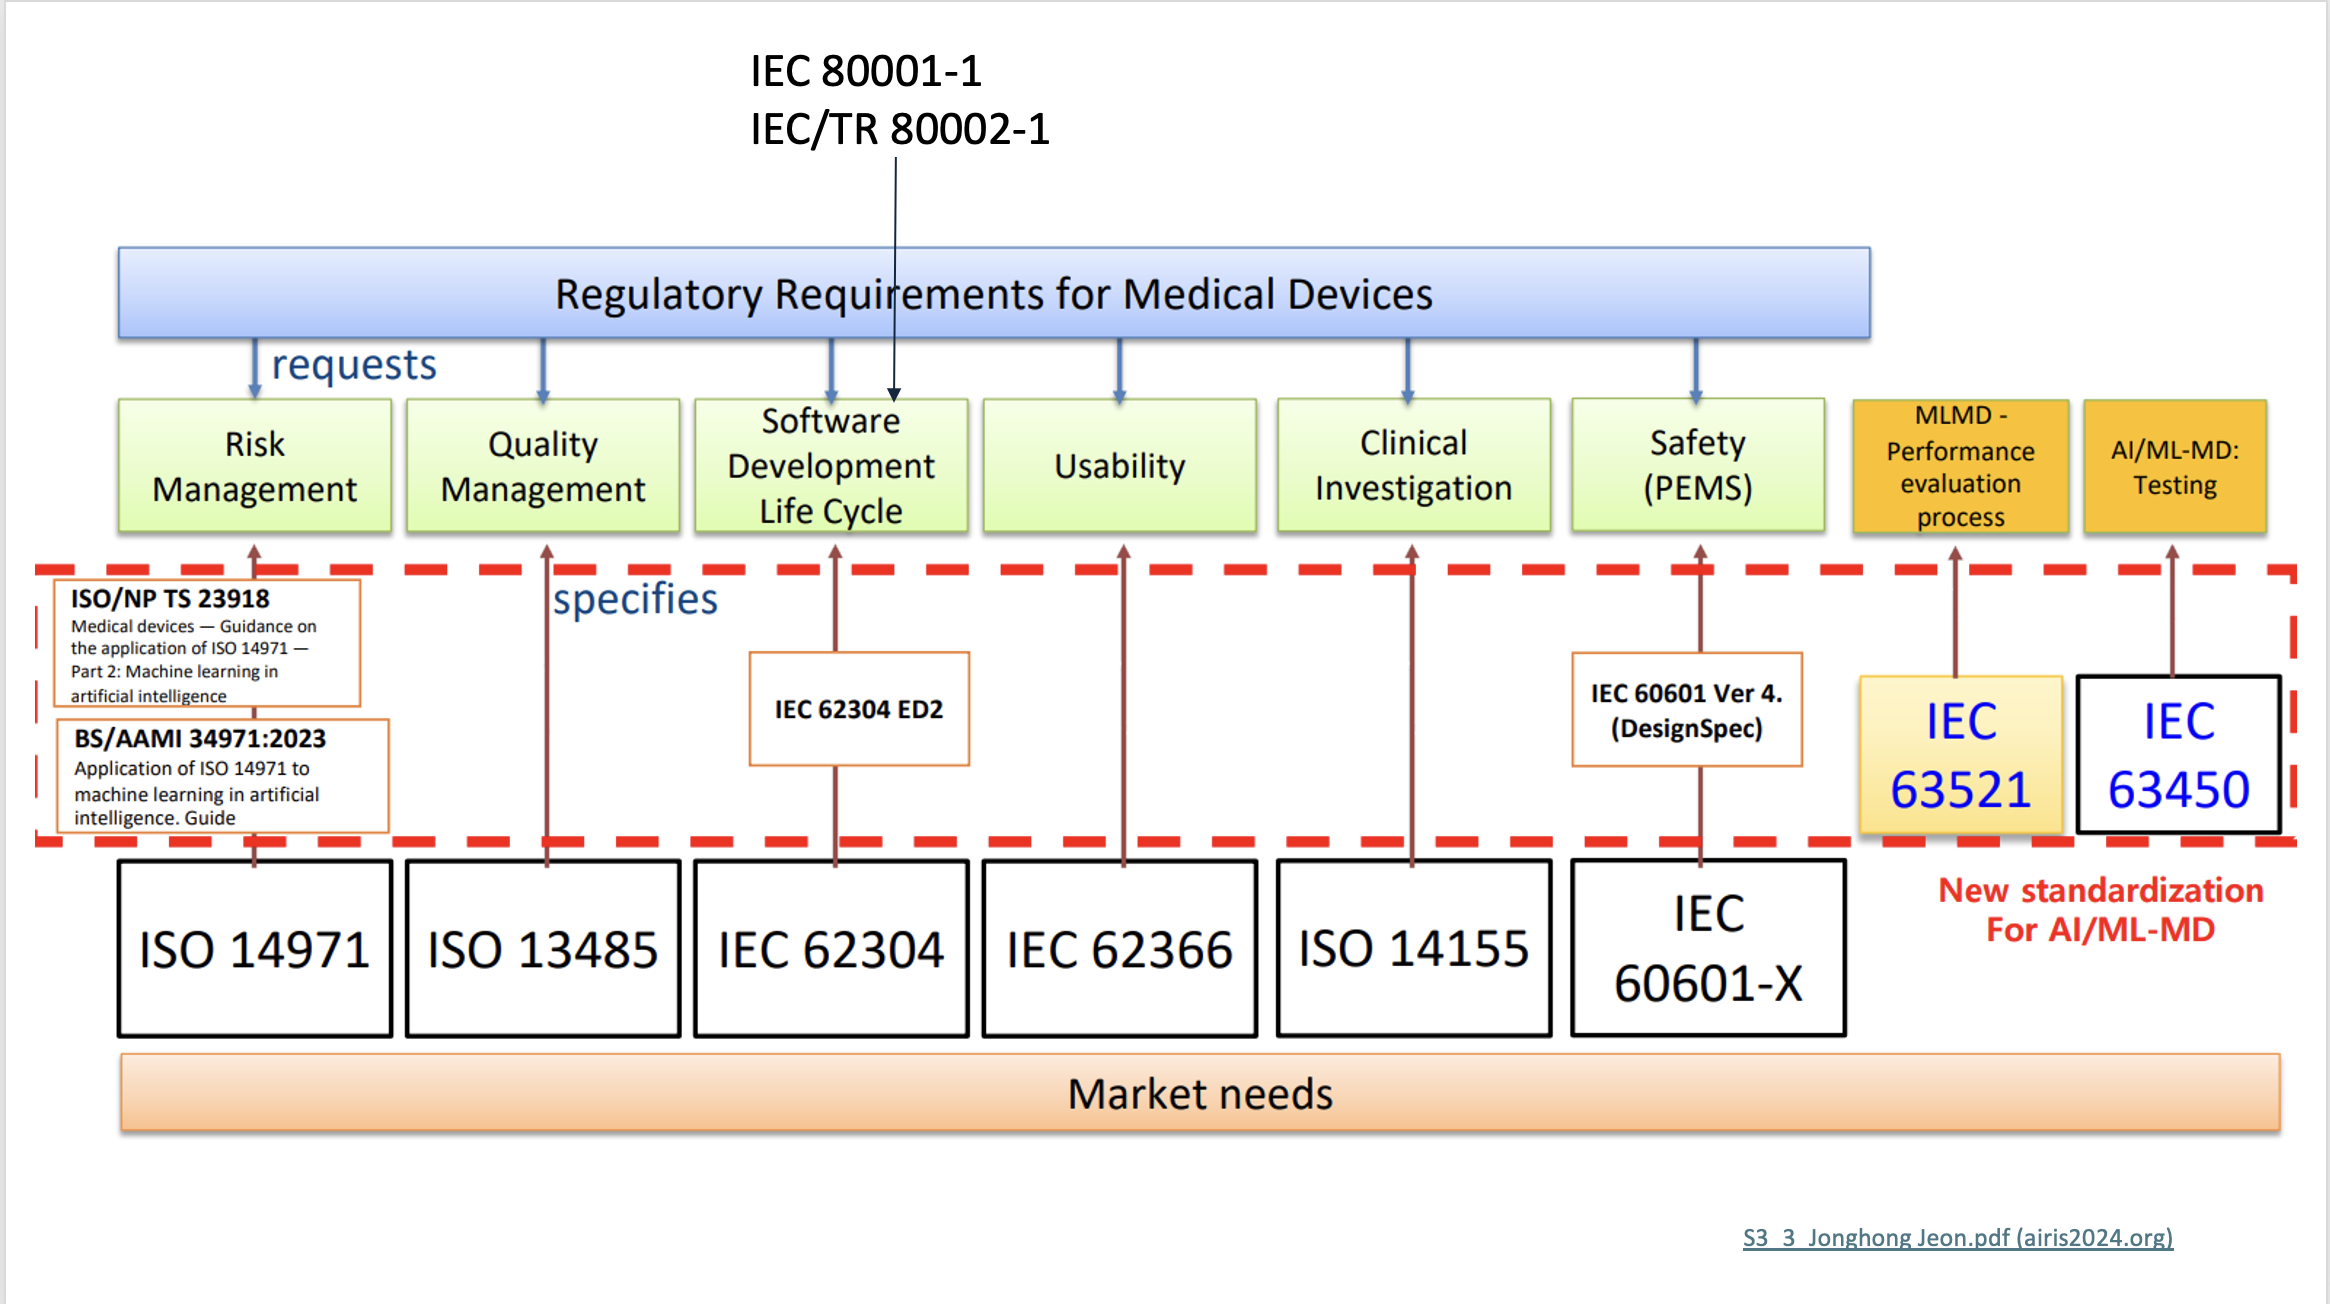

### Technical evaluation is not a substitute for Clinical Evaluation
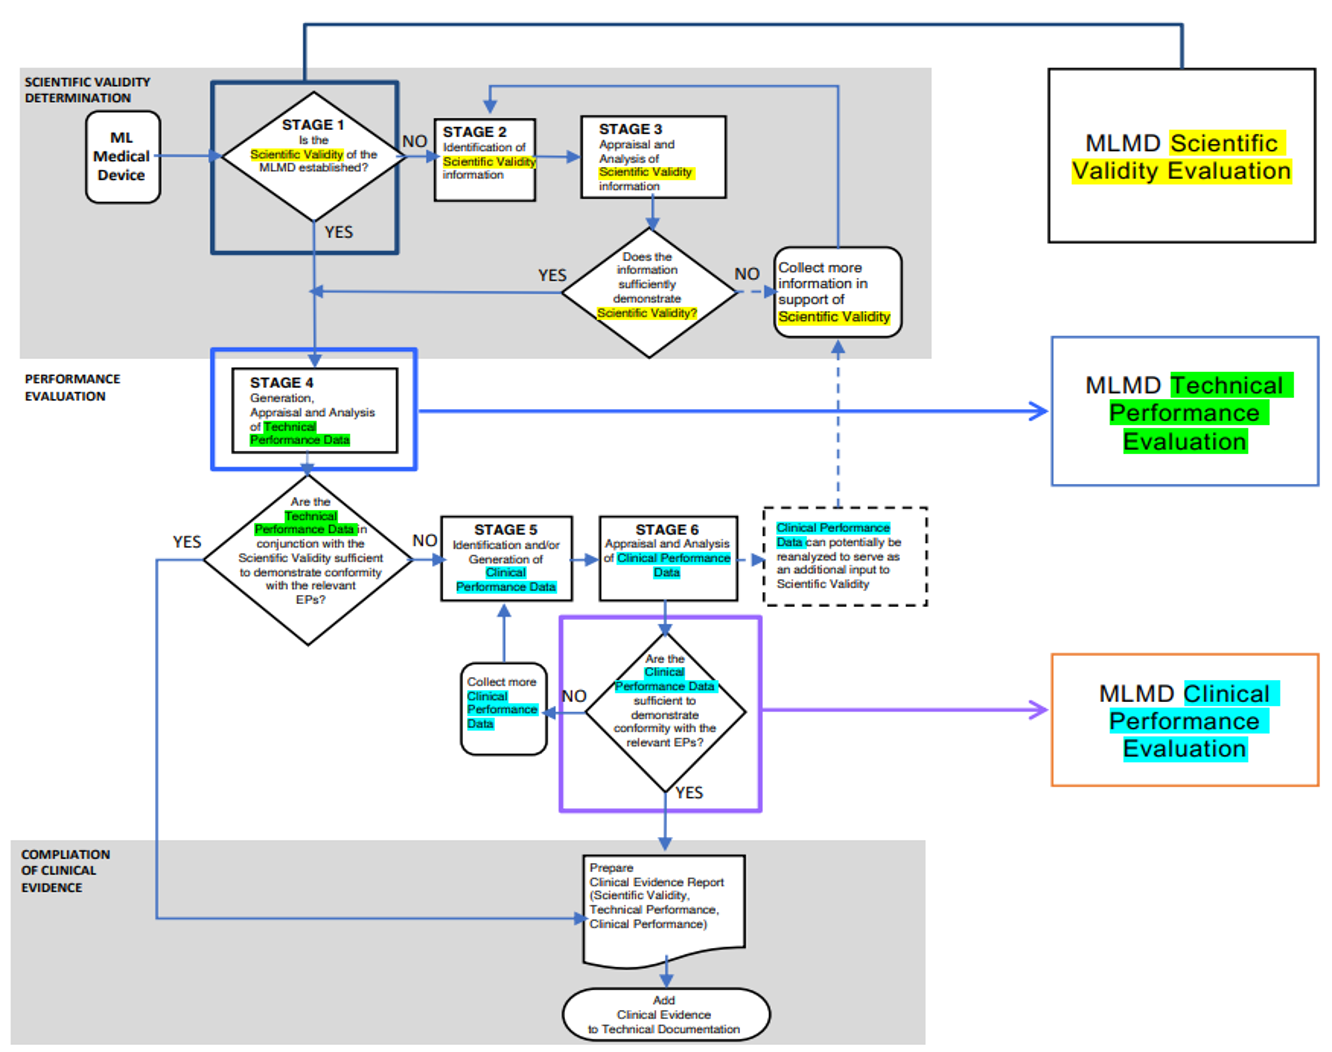

### When in doubt; preserve it!

* Preserve raw data
* Preserve the process of handling the data (missing, outliers, standardization, modification of any kind)
* Preserve final data
* Document data representation (Imbalance, metadata etc.)
* Document algorithms (all tested, reason to choose the best one, reason for selecting methods like stacking/blending, hyperparameter tuning grids and methodologies)
* Document Metrics (Accuracy, Recall, Precision, F1 etc.
* Miscellaneous - Random seeds for replicability, all code, version controls, final artifacts before submission, dependency on the previous versions of models (Lineages)
